In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler

# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import time

C:\Users\mimam\AppData\Local\Temp\ipykernel_28144\1048350913.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('./store5.csv')
data

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.000,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.000,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.000,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.000,0,NaN
4,1456,2013-01-01,5,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
55567,3000586,2017-08-15,5,POULTRY,241.011,1,47.57
55568,3000587,2017-08-15,5,PREPARED FOODS,52.121,0,47.57
55569,3000588,2017-08-15,5,PRODUCE,1357.823,4,47.57
55570,3000589,2017-08-15,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57


In [3]:
data['dcoilwtico'] = data['dcoilwtico'].ffill()
data['dcoilwtico'] = data['dcoilwtico'].bfill()
data['dcoilwtico'].isnull().sum()

0

In [4]:
hardware = data.loc[data['family'] == 'HARDWARE']
hardware = hardware.drop(columns = ['id', 'store_nbr', 'family'])
hardware['date'] = pd.to_datetime(hardware['date'])
hardware = hardware.set_index('date')
hardware

,sales,onpromotion,dcoilwtico
date,,,
2013-01-01,0.0,0,93.14
2013-01-02,3.0,0,93.14
2013-01-03,0.0,0,92.97
2013-01-04,1.0,0,93.12
2013-01-05,1.0,0,93.12
...,...,...,...
2017-08-11,2.0,0,48.81
2017-08-12,1.0,0,48.81
2017-08-13,3.0,0,48.81


In [5]:
hardware['year'] = hardware.index.year
hardware['month'] = hardware.index.month
hardware['week'] = hardware.index.isocalendar().week
hardware['day'] = hardware.index.day
hardware['day of the week'] = hardware.index.weekday

In [6]:
from sklearn.preprocessing import LabelEncoder

# Contoh data tahun
tahun = [2013, 2014, 2015, 2016, 2017]

# Inisialisasi dan fitting LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(hardware['year'])

# Transformasi data tahun
hardware['year'] = label_encoder.transform(hardware['year']) + 1
hardware['week'] = hardware['week'].astype(int)
hardware.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1684 entries, 2013-01-01 to 2017-08-15
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sales            1684 non-null   float64
 1   onpromotion      1684 non-null   int64  
 2   dcoilwtico       1684 non-null   float64
 3   year             1684 non-null   int64  
 4   month            1684 non-null   int32  
 5   week             1684 non-null   int32  
 6   day              1684 non-null   int32  
 7   day of the week  1684 non-null   int32  
dtypes: float64(2), int32(4), int64(2)
memory usage: 92.1 KB


# LSTM

In [7]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x = hardware[['dcoilwtico', 'onpromotion']].copy()
y = hardware['sales'].copy()

x['dcoilwtico'] = x_scaler.fit_transform(x['dcoilwtico'].values.reshape(-1, 1))
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [8]:
def load_data(X, seq_len, test_size=30):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_data = data[:-test_size]  # Exclude last 'test_size' data points for test set
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[-test_size:, :-1] 
    y_test = data[-test_size:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

window = 7
x['sales'] = y
X_train, y_train, X_test, y_test = load_data(x, window,test_size=30)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1646, 7, 3) (1646,) (30, 7, 3) (30,)


In [9]:
#LSTM architecture
modelLSTM = Sequential()

# First LSTM layer with Dropout regularisation
modelLSTM.add(LSTM(units=15, input_shape=(window,3)))
modelLSTM.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

# Compiling the RNN
modelLSTM.compile(optimizer='adam',loss='mse')
# Fitting to the training set
start = time.time()
history1=modelLSTM.fit(X_train,y_train,epochs=100,batch_size=10, validation_split=0.05, verbose=1)
print ('compilation time : ', time.time() - start)



Epoch 1/100

157/157 [==============================] - 4s 10ms/step - loss: 0.0195 - val_loss: 0.0252
Epoch 2/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0178 - val_loss: 0.0247
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0177 - val_loss: 0.0245
Epoch 4/100
157/157 [==============================] - 1s 6ms/step - loss: 0.0177 - val_loss: 0.0247
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0177 - val_loss: 0.0251
Epoch 6/100
157/157 [==============================] - 1s 6ms/step - loss: 0.0176 - val_loss: 0.0246
Epoch 7/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0241
Epoch 8/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0246
Epoch 9/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0177 - val_loss: 0.0252
Epoch 10/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0177 - va

In [10]:
trainPredict = modelLSTM.predict(X_train)
testPredict = modelLSTM.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(30, 1)

plot_actual = testY.copy()
plot_actual = plot_actual.reshape(30, 1)

print(plot_actual.shape)
print(plot_predicted.shape)

1/1 [==============================] - 0s 34ms/step
(30, 1)
(30, 1)


In [11]:
plot_predicted.shape

(30, 1)

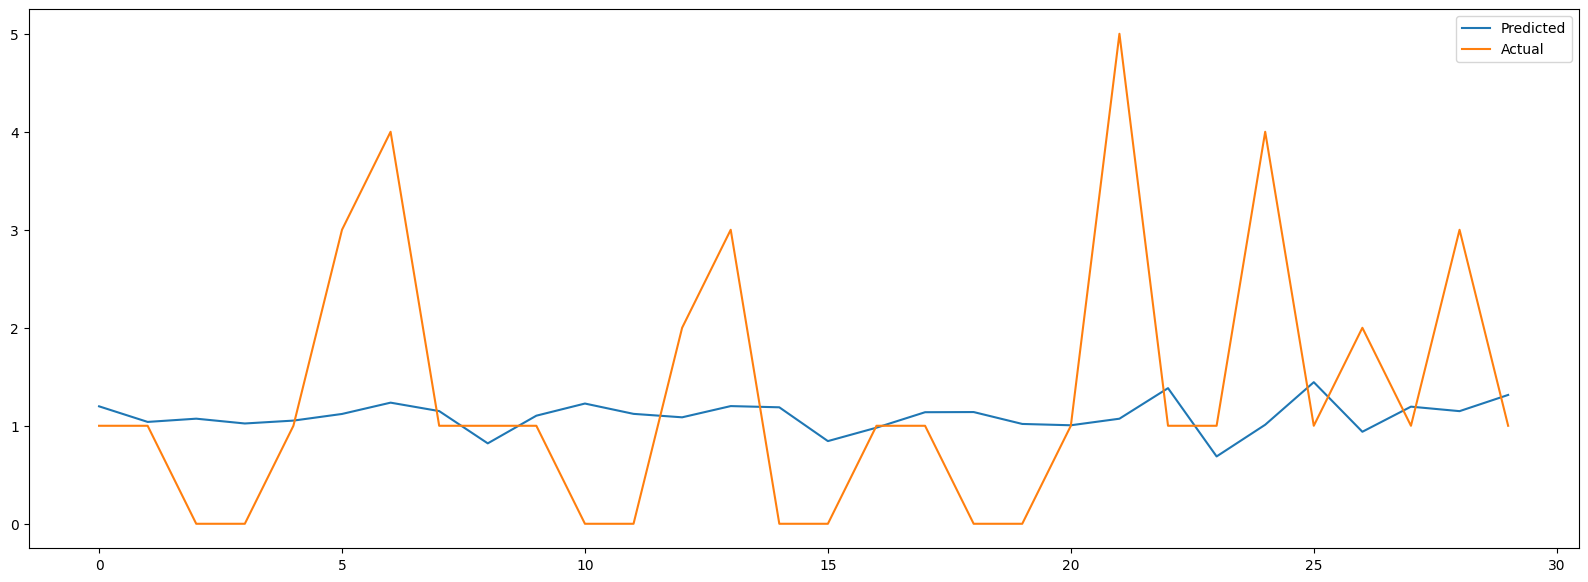

In [12]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [13]:
test = hardware[-30:]
# Input into pandas dataframe, test as index and plot_predicted as the column
# Reshape the data plot_predicted
plot_predicted = plot_predicted.reshape(30,)
plot_actual = plot_actual.reshape(30,)

forecastLSTM = pd.DataFrame({'test': plot_actual, 'forecast': plot_predicted}, index=test.index)
forecastLSTM

,test,forecast
date,,
2017-07-17,1.0,1.198539
2017-07-18,1.0,1.039405
2017-07-19,0.0,1.072405
2017-07-20,0.0,1.023469
2017-07-21,1.0,1.052812
2017-07-22,3.0,1.120628
2017-07-23,4.0,1.235938
2017-07-24,1.0,1.149996
2017-07-25,1.0,0.820526


# STACKED LSTM

In [14]:
#LSTM architecture
model2 = Sequential()
# First LSTM layer with Dropout regularisation
model2.add(LSTM(units=15, input_shape=(window,3),return_sequences=True))

# Second LSTM layer
model2.add(LSTM(units=15))

# The output layer
model2.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))
model2.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model2.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history2=model2.fit(X_train,y_train,epochs=100,batch_size=10, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100
157/157 [==============================] - 7s 14ms/step - loss: 0.0203 - val_loss: 0.0262
Epoch 2/100
157/157 [==============================] - 1s 7ms/step - loss: 0.0178 - val_loss: 0.0245
Epoch 3/100
157/157 [==============================] - 1s 8ms/step - loss: 0.0177 - val_loss: 0.0259
Epoch 4/100
157/157 [==============================] - 1s 8ms/step - loss: 0.0177 - val_loss: 0.0253
Epoch 5/100
157/157 [==============================] - 1s 9ms/step - loss: 0.0177 - val_loss: 0.0253
Epoch 6/100
157/157 [==============================] - 1s 9ms/step - loss: 0.0177 - val_loss: 0.0251
Epoch 7/100
157/157 [==============================] - 1s 9ms/step - loss: 0.0177 - val_loss: 0.0250
Epoch 8/100
157/157 [==============================] - 1s 9ms/step - loss: 0.0177 - val_loss: 0.0255
Epoch 9/100
157/157 [==============================] - 1s 8ms/step - loss: 0.0177 - val_loss: 0.0244
Epoch 10/100
157/157 [==============================] - 1s 10ms/step - loss: 0.0177 - val_

In [15]:
trainPredict = model2.predict(X_train)
testPredict = model2.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(30, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(30, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

1/1 [==============================] - 0s 36ms/step
(30, 1)
(30, 1)


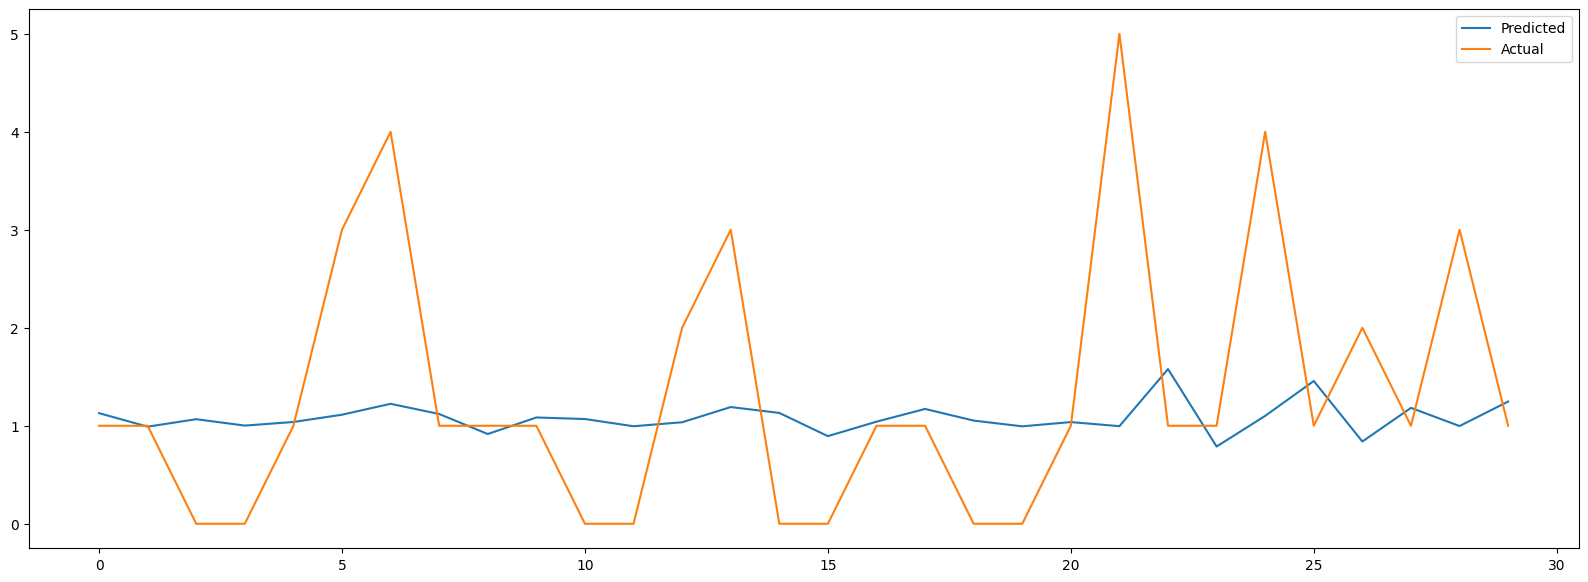

In [16]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [17]:
plot_predicted = plot_predicted.reshape(30,)
plot_actual = plot_actual.reshape(30,)

forecastSLSTM = pd.DataFrame({'test': plot_actual, 'forecast': plot_predicted}, index=test.index)
forecastSLSTM

,test,forecast
date,,
2017-07-17,1.0,1.128809
2017-07-18,1.0,0.990854
2017-07-19,0.0,1.067032
2017-07-20,0.0,1.001898
2017-07-21,1.0,1.038683
2017-07-22,3.0,1.113010
2017-07-23,4.0,1.224126
2017-07-24,1.0,1.120162
2017-07-25,1.0,0.915971


# BILSTM

In [18]:
# Stack LSTM architecture
model3 = Sequential()
# Bidirectional LSTM
model3.add(Bidirectional(LSTM(units=15), input_shape=(window,3)))

# The output layer
model3.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))
model3.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model3.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history3=model3.fit(X_train,y_train,epochs=100,batch_size=10, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100
157/157 [==============================] - 7s 13ms/step - loss: 0.0202 - val_loss: 0.0256
Epoch 2/100
157/157 [==============================] - 1s 6ms/step - loss: 0.0179 - val_loss: 0.0255
Epoch 3/100
157/157 [==============================] - 1s 6ms/step - loss: 0.0178 - val_loss: 0.0259
Epoch 4/100
157/157 [==============================] - 1s 6ms/step - loss: 0.0177 - val_loss: 0.0254
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0177 - val_loss: 0.0251
Epoch 6/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0177 - val_loss: 0.0248
Epoch 7/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0241
Epoch 8/100
157/157 [==============================] - 1s 7ms/step - loss: 0.0177 - val_loss: 0.0249
Epoch 9/100
157/157 [==============================] - 1s 6ms/step - loss: 0.0176 - val_loss: 0.0244
Epoch 10/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0176 - val_l

In [19]:
trainPredict = model3.predict(X_train)
testPredict = model3.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(30, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(30, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

1/1 [==============================] - 0s 34ms/step
(30, 1)
(30, 1)


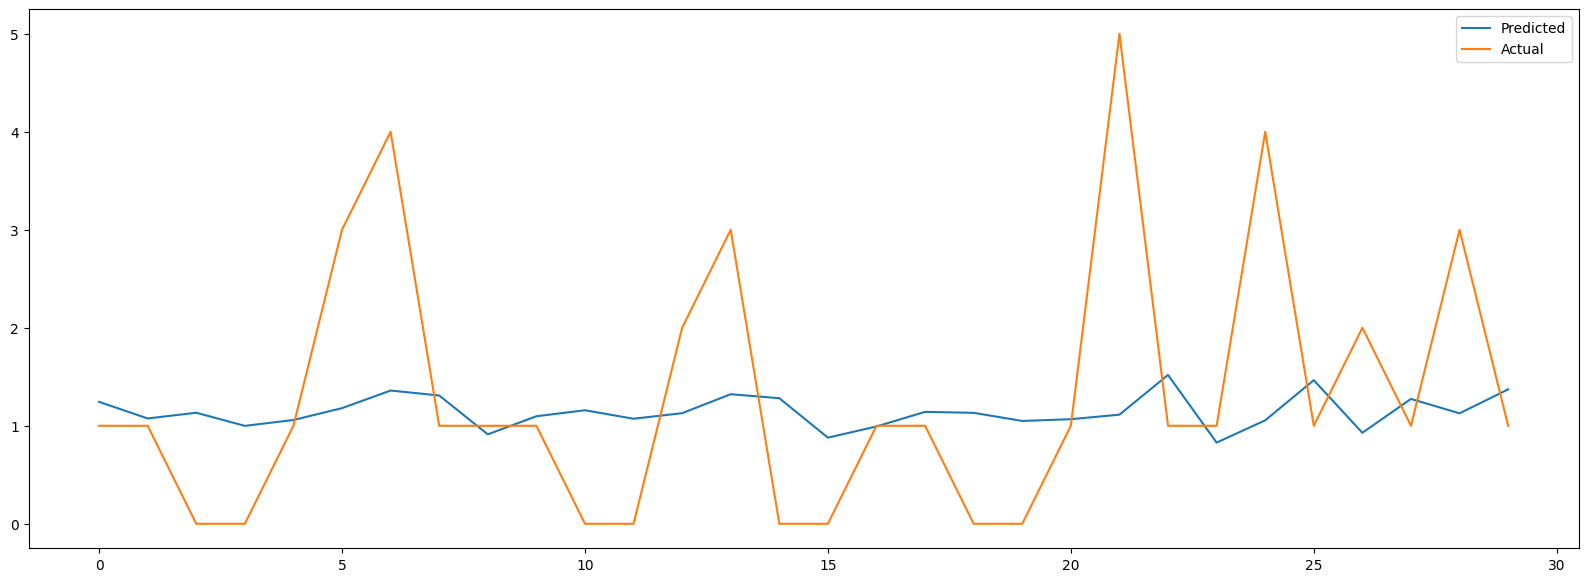

In [20]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [21]:
plot_predicted = plot_predicted.reshape(30,)
plot_actual = plot_actual.reshape(30,)

forecastBILSTM = pd.DataFrame({'test': plot_actual, 'forecast': plot_predicted}, index=test.index)
forecastBILSTM

,test,forecast
date,,
2017-07-17,1.0,1.244246
2017-07-18,1.0,1.074604
2017-07-19,0.0,1.133155
2017-07-20,0.0,0.999265
2017-07-21,1.0,1.058789
2017-07-22,3.0,1.179898
2017-07-23,4.0,1.359583
2017-07-24,1.0,1.309192
2017-07-25,1.0,0.912561


In [22]:
model = [forecastLSTM, forecastSLSTM, forecastBILSTM]
model_name = ['LSTM', 'Stacked LSTM', 'BILSTM']
metrics = []

for i in range(len(model)):
    mae = mean_absolute_error(model[i]['test'], model[i]['forecast'])
    mse = mean_squared_error(model[i]['test'], model[i]['forecast'])
    r2 = r2_score(model[i]['test'], model[i]['forecast'])
    metrics.append([mae, mse, r2])
    
metrics = pd.DataFrame(metrics, columns=['MAE', 'MSE', 'R2'], index=model_name)
metrics.sort_values(by = ['R2'], ascending = False)

,MAE,MSE,R2
BILSTM,0.945906,1.759792,-0.002413
LSTM,0.945269,1.809675,-0.030828
Stacked LSTM,0.936732,1.815874,-0.034358


In [23]:
hardware.tail(30)

,sales,onpromotion,dcoilwtico,year,month,week,day,day of the week
date,,,,,,,,
2017-07-17,1.0,0,46.02,5,7,29,17,0
2017-07-18,0.0,0,46.40,5,7,29,18,1
2017-07-19,0.0,0,47.10,5,7,29,19,2
2017-07-20,1.0,0,46.73,5,7,29,20,3
2017-07-21,3.0,0,45.78,5,7,29,21,4
2017-07-22,4.0,0,45.78,5,7,29,22,5
2017-07-23,1.0,0,45.78,5,7,29,23,6
2017-07-24,1.0,0,46.21,5,7,30,24,0
2017-07-25,1.0,0,47.77,5,7,30,25,1
